In [ ]:
import sys
# extending path to be able to import tudaesasII from the parent directory
sys.path.append('../..')

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]
matplotlib.rcParams['lines.linewidth'] = 2
import numpy as np
from numpy import pi
from scipy.linalg import cholesky, eigh, solve
from composites import isotropic_plate

from tudaesasII.quad4r import Quad4R, update_K, update_M, DOF

def mag2db(mag):
    return 20*np.log10(mag)

nx = 15
ny = 15

a = 0.300 # [m]
b = 0.274 # [m]

E = 70.e9 # Pa
nu = 0.33
rho = 2.7e3 # kg/m3
h = 0.001 # m

xtmp = np.linspace(0, a, nx)
ytmp = np.linspace(0, b, ny)
xmesh, ymesh = np.meshgrid(xtmp, ytmp)
ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten())).T
x = ncoords[:, 0]
y = ncoords[:, 1]

nids = 1 + np.arange(ncoords.shape[0])
nid_pos = dict(zip(nids, np.arange(len(nids))))
nids_mesh = nids.reshape(nx, ny)
n1s = nids_mesh[:-1, :-1].flatten()
n2s = nids_mesh[1:, :-1].flatten()
n3s = nids_mesh[1:, 1:].flatten()
n4s = nids_mesh[:-1, 1:].flatten()

plate = isotropic_plate(thickness=h, E=E, nu=nu, calc_scf=True)

N = DOF*nx*ny
K = np.zeros((N, N))
M = np.zeros((N, N))
quads = []

for n1, n2, n3, n4 in zip(n1s, n2s, n3s, n4s):
    pos1 = nid_pos[n1]
    pos2 = nid_pos[n2]
    pos3 = nid_pos[n3]
    pos4 = nid_pos[n4]
    r1 = ncoords[pos1]
    r2 = ncoords[pos2]
    r3 = ncoords[pos3]
    normal = np.cross(r2 - r1, r3 - r2)
    assert normal > 0 # guaranteeing that all elements have CCW positive normal
    quad = Quad4R()
    quad.rho = rho
    quad.n1 = n1
    quad.n2 = n2
    quad.n3 = n3
    quad.n4 = n4
    quad.scf13 = plate.scf_k13
    quad.scf23 = plate.scf_k23
    quad.h = h
    quad.A = plate.A
    quad.B = plate.B
    quad.D = plate.D
    quad.Atrans = plate.Atrans
    update_K(quad, nid_pos, ncoords, K)
    update_M(quad, nid_pos, ncoords, M)
    quads.append(quad)

bk = np.zeros(N, dtype=bool) # constrained DOFs, can be used to prescribe displacements
# eliminating u and v
bk[0::DOF] = True
bk[1::DOF] = True
check = np.isclose(x, 0) | np.isclose(x, a) | np.isclose(y, 0) | np.isclose(y, b)
bk[2::DOF] = check

# unknown DOFs
bu = ~bk

# sub-matrices corresponding to unknown DOFs
Kuu = K[bu, :][:, bu]
Muu = M[bu, :][:, bu]
Kuk = K[bu, :][:, bk]
Muk = M[bu, :][:, bk]

L = cholesky(M, lower=True)
Luu = L[bu, :][:, bu]
Luuinv = np.linalg.inv(Luu)
Ktilde = Luuinv @ Kuu @ Luuinv.T

rbmodes = 0
Nmodes = 40
gamma, Vu = eigh(Ktilde, subset_by_index=(0, Nmodes-1)) # already gives V[:, i] normalized to 1
Vu = Vu[:, rbmodes:]
gamma = gamma[rbmodes:]

omegan = gamma**0.5

V = np.zeros((N, Nmodes-rbmodes))
V[bu, :] = Vu

P = V
Pu = Vu

print('omegan [rad/s]', omegan)


omegan [rad/s] [  381.65856363   926.2720103   1031.61993471  1621.65064845
  1881.57457703  2172.09144596  2651.47874671  2837.39517988
  3332.93617077  3903.61194387  3989.85871416  4219.87658548
  4687.11101119  5406.98294159  5742.13548818  6025.63272679
  6378.9226342   6452.94364333  7324.11055859  8039.47599582
  8223.99557615  8314.65498549  8917.48605561  9590.284894
  9847.36212237 10861.27659229 11024.58797504 11277.91752619
 11716.10749263 12370.27570835 12981.14872323 13953.26298379
 14536.74266339 14685.62977413 14818.4556427  15820.53973697
 16174.83069634 16553.74534146 18096.06451293 18620.68982201]


Modal Frequency Response Analysis (with base excitation)
===
Damping matrix C calculated from modal damping ratio
---

In [2]:
zeta = 0.02
Dm = np.zeros((Nmodes-rbmodes, Nmodes-rbmodes))
Dm[np.diag_indices_from(Dm)] = 2*zeta*omegan
C = L @ P @ Dm @ P.T @ L.T
Cuk = C[bu, :][:, bk]

Sine sweep analysis
---

In [3]:
amplitude = 0.0001
at_edges = np.isclose(x, 0) | np.isclose(x, a) | np.isclose(y, 0) | np.isclose(y, b)
u = np.zeros(N)
u[2::DOF] = at_edges*amplitude
uk = u[bk]

displs = []
U = np.zeros(K.shape[0], dtype=np.complex128)
omegas = np.linspace(0, 4200, 1000) #frequency sweep in rad/s
for omegaf in omegas:
    dukdt = 1j*omegaf*uk
    d2ukdt2 = -omegaf**2*uk
    Fk = - Muk @ d2ukdt2 - Cuk @ dukdt - Kuk @ uk 
    
    # NOTE Direct FRA
    # 1) Calculate the frequency response matrix
    # Huu = -Muu*omegaf**2 + Cuu*1j*omegaf + Kuu
    # 2) Solve for the displacement frequency response
    # Uu = solve(Huu, Fk)
    
    # NOTE Modal FRA
    # 1) calculate modal force
    fmodal = Pu.T @ Luuinv @ Fk
    # 2) calculate the analytical FRF
    H = 1/(-omegaf**2 + 2*zeta*1j*omegaf*omegan + omegan**2)
    # 3) calculate the modal frequency response
    r = H*fmodal
    # 4) convert modal into displacement frequency response
    Uu = Luuinv.T @ Pu @ r
    
    U[bu] = Uu
    U[bk] = uk
    displs.append(U[2::DOF].copy())
displs = np.asarray(displs)
print(omegan[omegan < omegas.max()])
print('ready')

[ 381.65856363  926.2720103  1031.61993471 1621.65064845 1881.57457703
 2172.09144596 2651.47874671 2837.39517988 3332.93617077 3903.61194387
 3989.85871416]
ready


ready


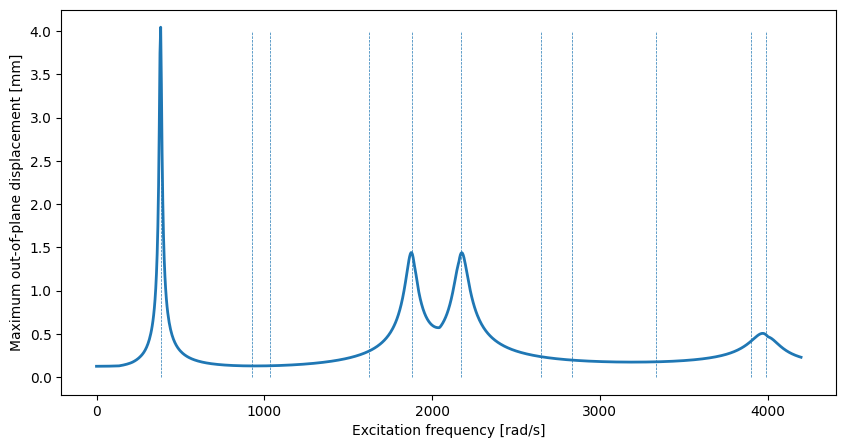

In [4]:
%matplotlib inline
plt.plot(omegas, np.abs(displs).max(axis=1)*1000)
plt.vlines(x=[omegan[omegan < omegas.max()]], ymin=0, ymax=4, ls='--', lw=0.5)
plt.ylabel('Maximum out-of-plane displacement [mm]')
plt.xlabel('Excitation frequency [rad/s]')
print('ready')